# Run MCMC for JIMWLK

In [1]:
from src import workdir, parse_model_parameter_file
from src.mcmc import Chain

import os
import pickle

In [2]:
def read_real_parameters(file):
    with open(file, "rb") as pf:
        data = pickle.load(pf)
    return data['000']['parameter']

In [ ]:
exp_path = "./exp_data_JIMWLK_LOG.pkl"
model_par = "./IP_DIFF_JIMWLK_prior_range_delete_unused"
mymcmc_PCSK = Chain(expdata_path=exp_path, model_parafile=model_par, mcmc_path="./mcmc_PCSK/chain.pkl")
mymcmc_Scikit = Chain(expdata_path=exp_path, model_parafile=model_par, mcmc_path="./mcmc_Scikit/chain.pkl")

In [ ]:
emuPathList_PCSK = ["./emulator.pkl"]
mymcmc_PCSK.loadEmulator(emuPathList_PCSK)

emuPathList_Scikit = ["./emulator_scikit.pkl"]
mymcmc_Scikit.loadEmulator(emuPathList_Scikit)

In [ ]:
os.environ["OMP_NUM_THREADS"] = "1"
# may have to: export RDMAV_FORK_SAFE=1 before running the code
n_effective=8000
n_active=4000
n_prior=16000
sample="tpcn"
n_max_steps=100
random_state=42

n_total = 50000
n_evidence = 50000

pool = 12

sampler = mymcmc_PCSK.run_pocoMC(n_effective=n_effective, n_active=n_active,
                            n_prior=n_prior, sample=sample,
                            n_max_steps=n_max_steps, random_state=random_state,
                            n_total=n_total, n_evidence=n_evidence, pool=pool)

sampler1 = mymcmc_Scikit.run_pocoMC(n_effective=n_effective, n_active=n_active,
                            n_prior=n_prior, sample=sample,
                            n_max_steps=n_max_steps, random_state=random_state,
                            n_total=n_total, n_evidence=n_evidence, pool=pool)

In [3]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 15})

In [4]:
PARAMETER_NAMES = [
    r'$m\;[\mathrm{GeV}]$',
    r'$B_G\;[\mathrm{GeV}^{-2}]$',
    r'$B_{G,{\rm q}}\;[\mathrm{GeV}^{-2}]$',
    r'$\sigma_{Q_s}$',
    r'$Q_{s}/\mu$',
    r'$m_{\rm JIMWLK}$',
    r'$\Lambda_{\rm QCD}$',
    r'$\mathrm{UVdamp}$',
    r'$\omega$',
    r'$K$',
    ]

prior_ranges = [
    (0.02,2),
    (1,10),
    (0.05,3),
    (0,1.5),
    (0.05,1.5),
    (0.02,2),
    (0.0001,0.3),
    (0,1),
    (0,10),
    (0.1,1)
] 

def read_pkl_file_chain_pocoMC(PATH_pklfile_chains):
    """
    data is a dictionary containing:
    - 'chain'
    - 'weights'
    - 'logl'
    - 'logp'
    - 'logz'
    - 'logz_err'
    """
    with open(PATH_pklfile_chains, 'rb') as pf:
        data = pickle.load(pf)

    return data

In [5]:
def plot_corner_1dataset(n_parameters,data_array,filename,real_parameters=None):
    # check the dimension of the data array
    dim = len(data_array.shape)
    if dim == 3:
        samples = data_array[:,:,:].reshape((-1,n_parameters))
    elif dim == 2:
        samples = data_array[:,:].reshape((-1,n_parameters))
    else:
        raise ValueError("The data array should have 2 or 3 dimensions")

    # Create subplots
    fig, axes = plt.subplots(n_parameters, n_parameters, figsize=(25, 25), sharex='col', sharey='row')

    # Loop over each parameter pair
    for i in range(n_parameters):
        for j in range(n_parameters):
            ax = axes[i, j]

            if i == j:
                ax = fig.add_subplot(n_parameters, n_parameters, i * n_parameters + j + 1)
                ax.hist(samples[:, i], bins=20, color='g', histtype='step', density=True)
                ax.set_yticks([])
                ax.set_yticklabels([])
                if i != n_parameters-1:
                    ax.set_xticks([])
                    ax.set_xticklabels([])
                if i == n_parameters-1:
                    ax.tick_params(axis='x', rotation=45, labelsize=10)

                # Calculate percentiles
                percentiles = np.percentile(samples[:, i], [16, 50, 84])
                median = percentiles[1]
                upper = percentiles[2] - median
                lower = median - percentiles[0]

                ax.annotate(fr'${median:.2f}_{{-{lower:.2f}}}^{{+{upper:.2f}}}$', xy=(0.5, 1.05), xycoords='axes fraction', ha='center')

                # Add a vertical line representing the real value
                if real_parameters is not None:
                    real_value = real_parameters[i]
                    ax.axvline(x=real_value, color='k', linestyle='-')

                ax.set_xlim([prior_ranges[i][0], prior_ranges[i][1]])
            # Only fill the lower triangle
            if i > j:
                ax.hist2d(samples[:, j], samples[:, i], bins=20, cmap='Greens')


            # Set labels on the lowest and leftmost plots
            if i == n_parameters - 1:
                ax.set_xlabel(PARAMETER_NAMES[j])
            if j == 0:
                ax.set_ylabel(PARAMETER_NAMES[i])

            if i < j:
                ax.axis('off')

    # Remove space between subplots
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

    # Remove ticks and labels for the first and last plots
    axes[0, 0].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    axes[n_parameters - 1, n_parameters - 1].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

    # Rotate x-axis tick labels
    for ax in axes[-1]:
        ax.tick_params(axis='x', rotation=45, labelsize=10)

    # Rotate y-axis tick labels
    for ax in axes[:, 0]:
        ax.tick_params(axis='y', rotation=45, labelsize=10)

    plt.savefig(f"{filename}.pdf")

In [7]:
PATH_pklfile = './mcmc_PCSK_sep_emu_no_expcov/chain.pkl'
RUN1_DATA = read_pkl_file_chain_pocoMC(PATH_pklfile)

PATH_pklfile = './mcmc_PCSK_sep_emu_full_expcov/chain.pkl'
RUN2_DATA = read_pkl_file_chain_pocoMC(PATH_pklfile)

PATH_pklfile = './mcmc_PCSK_sep_emu_CMS_expcov/chain.pkl'
RUN3_DATA = read_pkl_file_chain_pocoMC(PATH_pklfile)

PATH_pklfile = './mcmc_PCSK_sep_emu_ALICE_expcov/chain.pkl'
RUN4_DATA = read_pkl_file_chain_pocoMC(PATH_pklfile)

PATH_pklfile = './mcmc_PCSK_sep_emu_offzero_expcov/chain.pkl'
RUN5_DATA = read_pkl_file_chain_pocoMC(PATH_pklfile)

PATH_pklfile = './mcmc_PCSK_sep_emu_closure/chain.pkl'
RUN6_DATA = read_pkl_file_chain_pocoMC(PATH_pklfile)

PATH_closure_test_data = './closure_test_point_JIMWLK.pkl'
real_parameters = read_real_parameters(PATH_closure_test_data)

PATH_pklfile = './mcmc_PCSK_sep_emu_notdiff_expcov/chain.pkl'
RUN7_DATA = read_pkl_file_chain_pocoMC(PATH_pklfile)


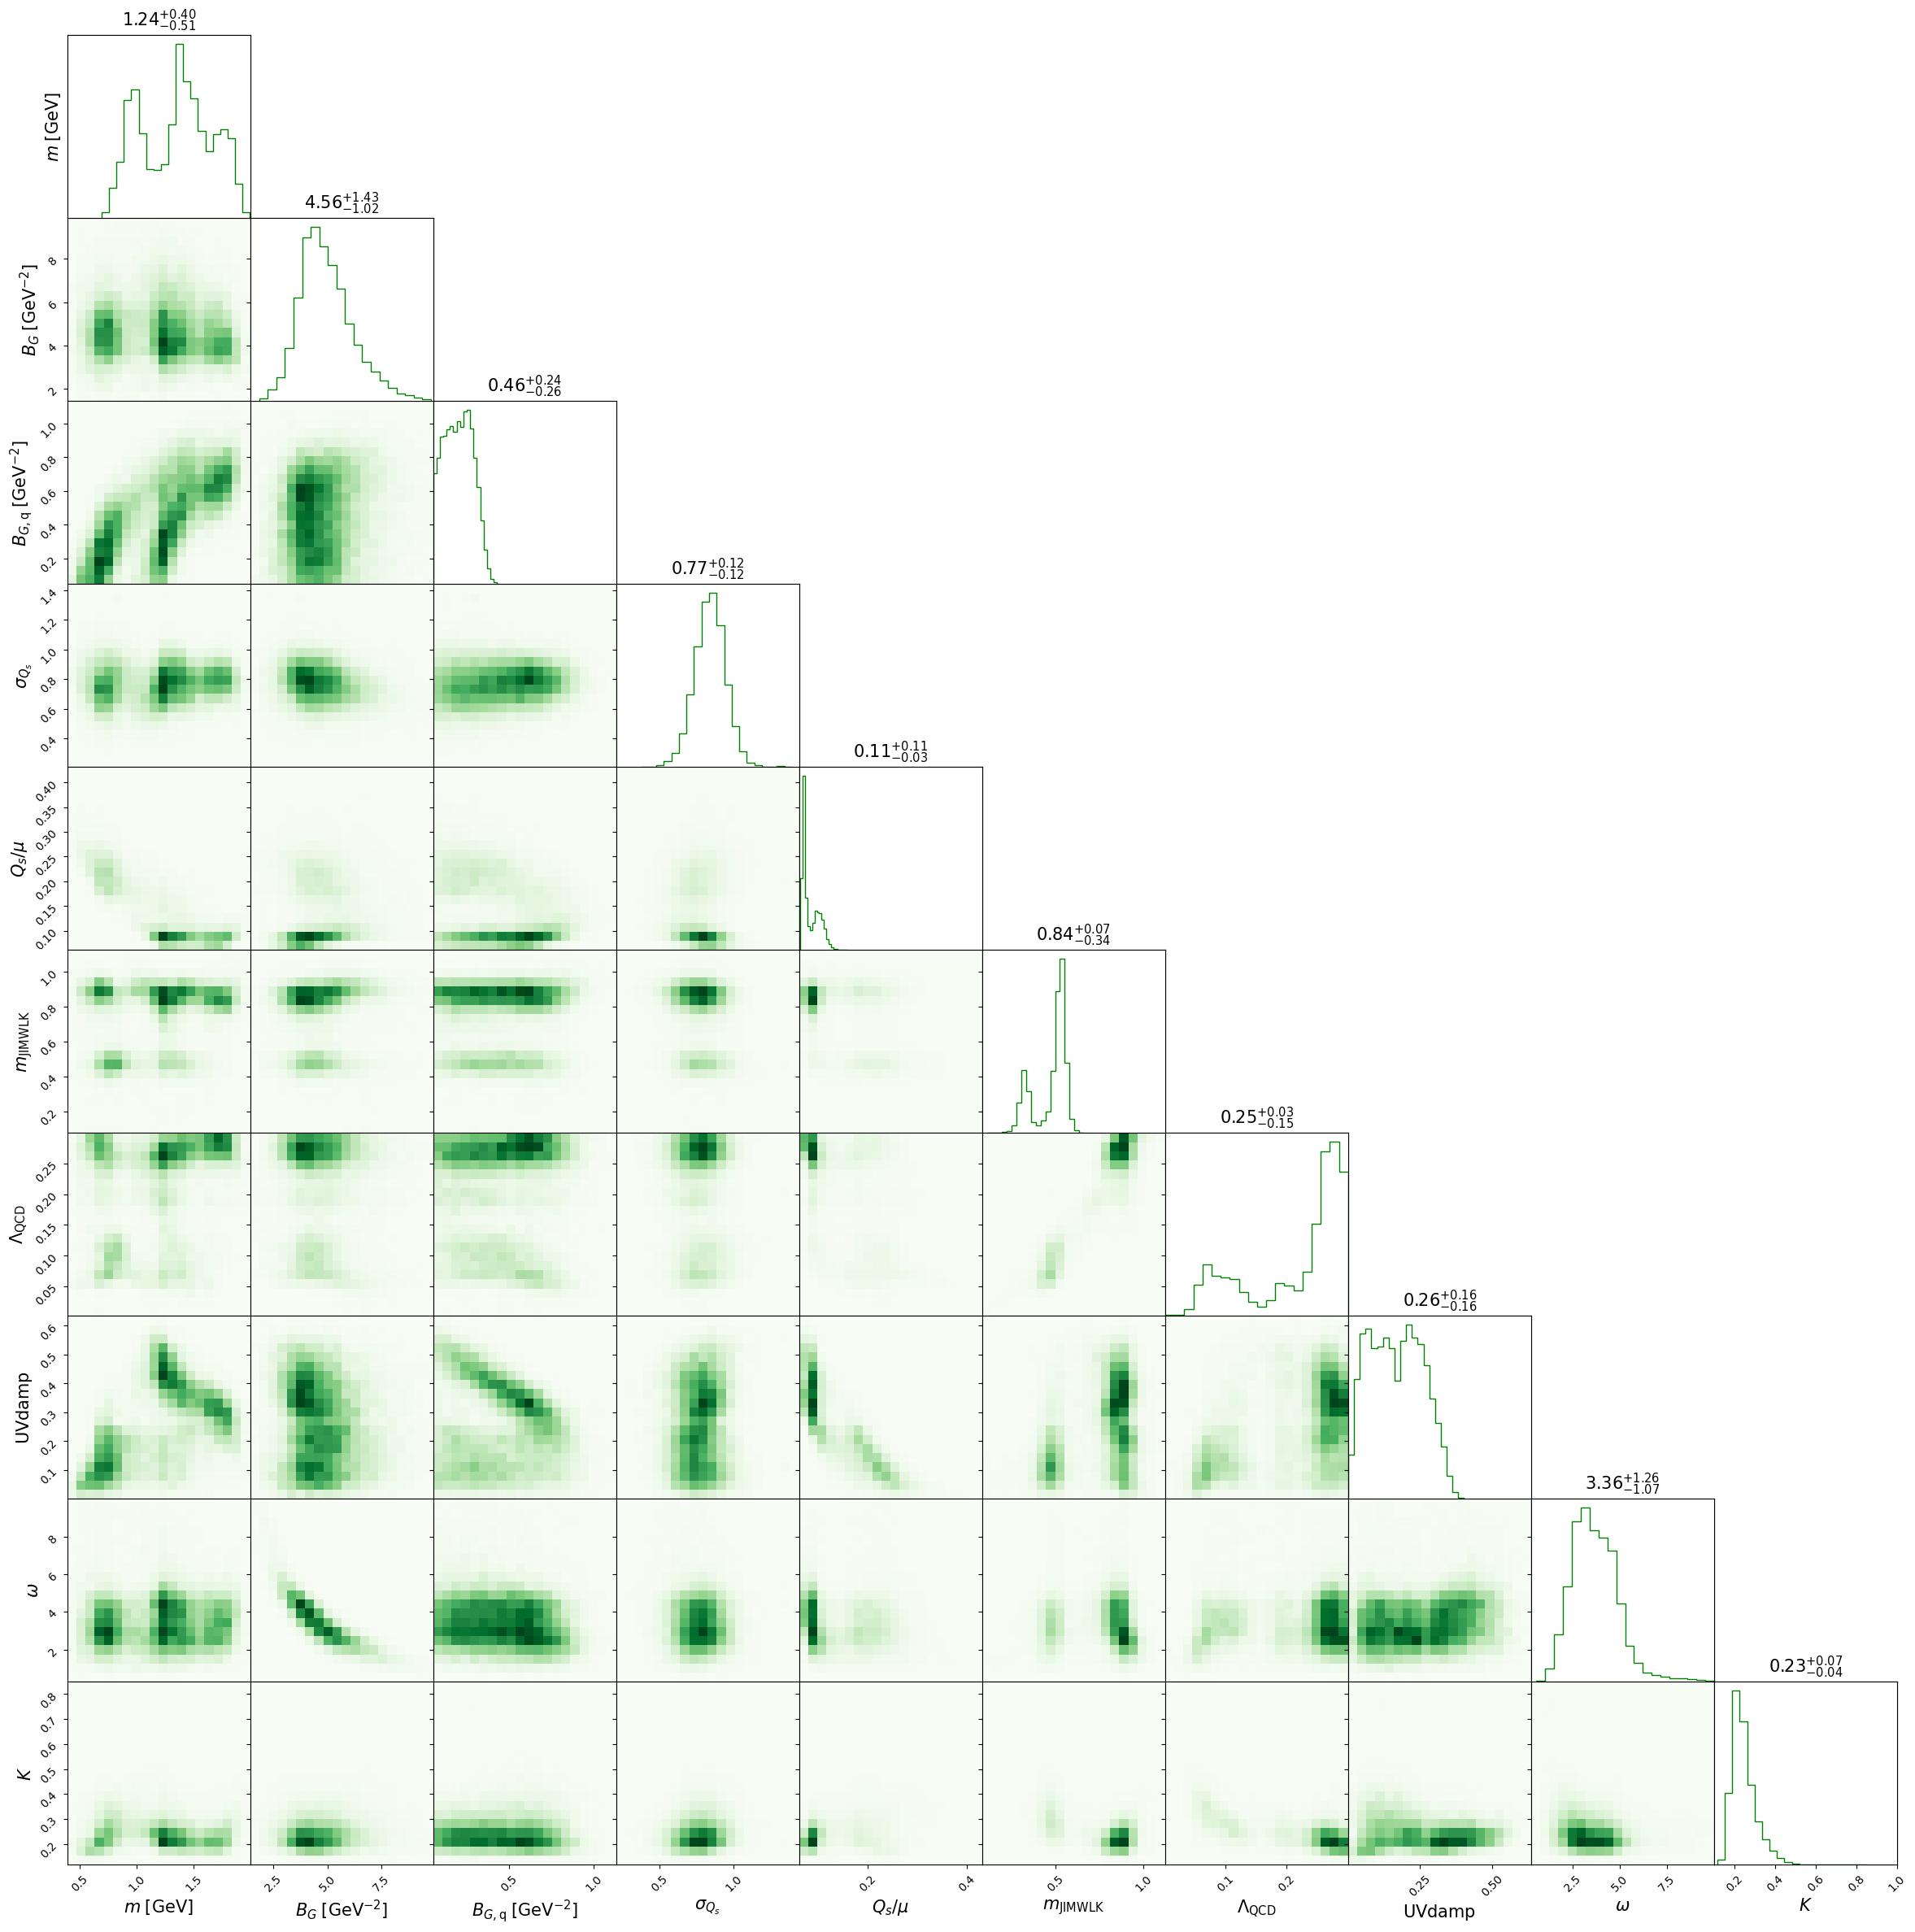

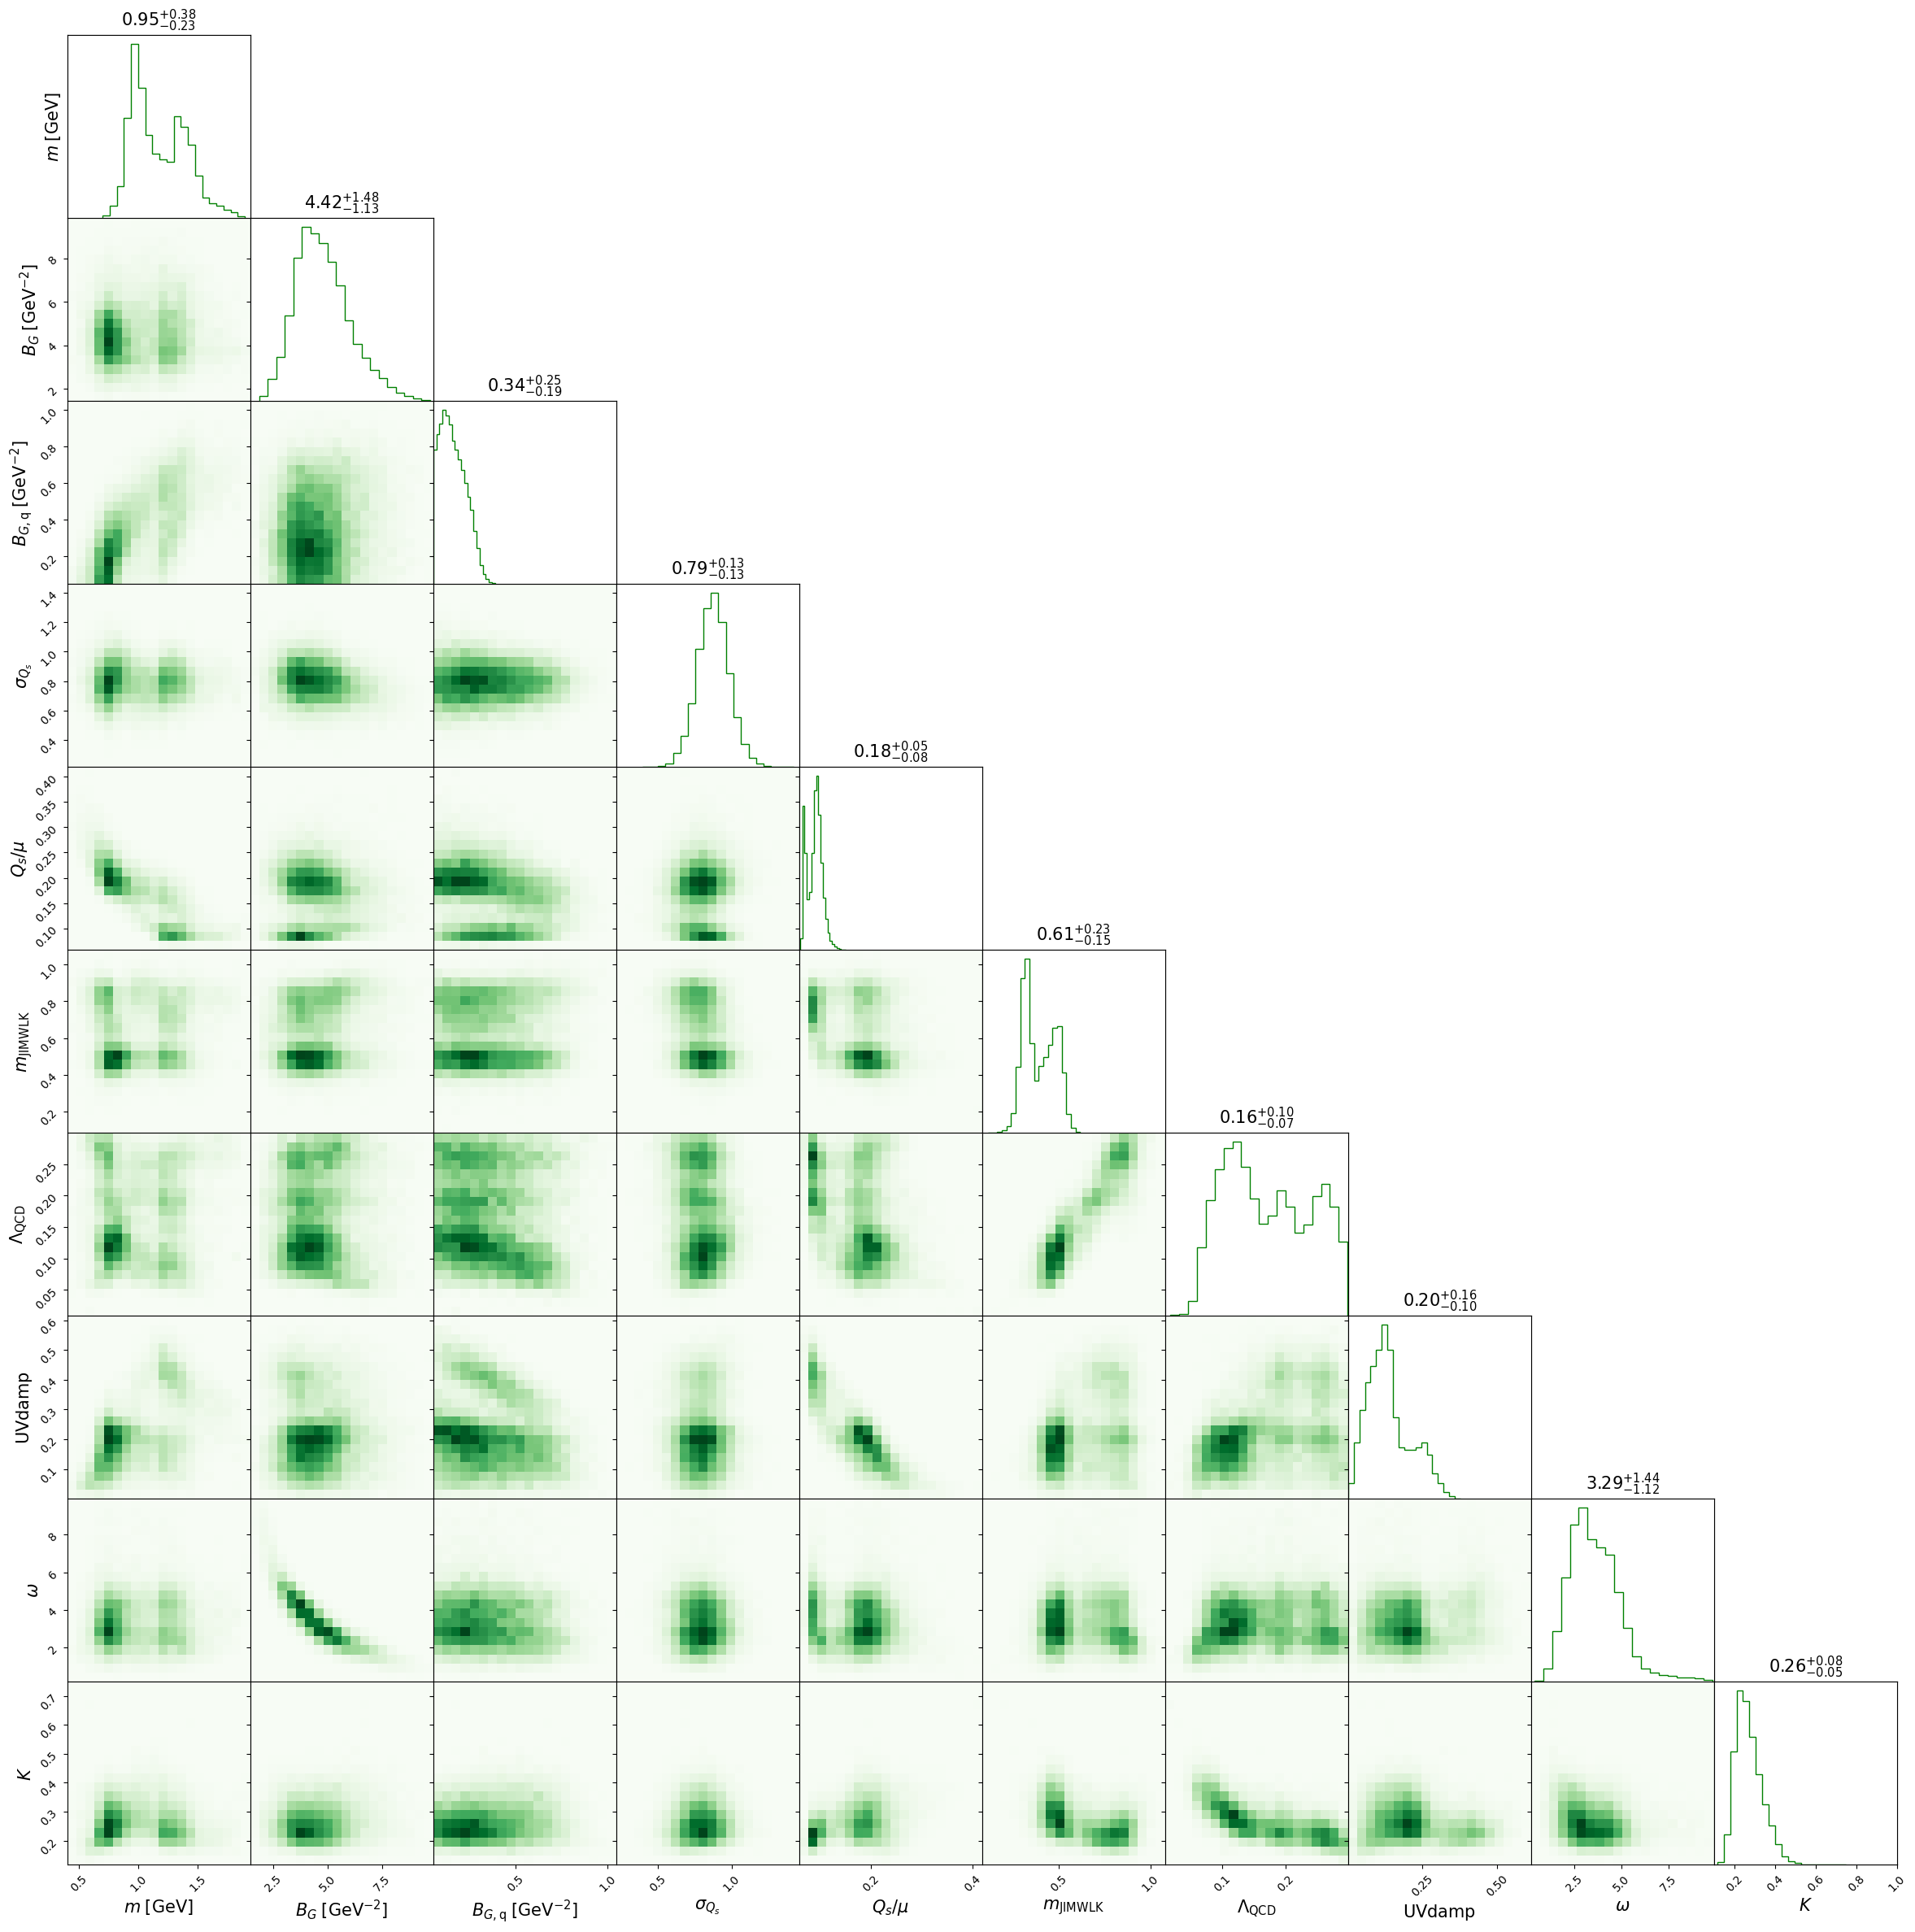

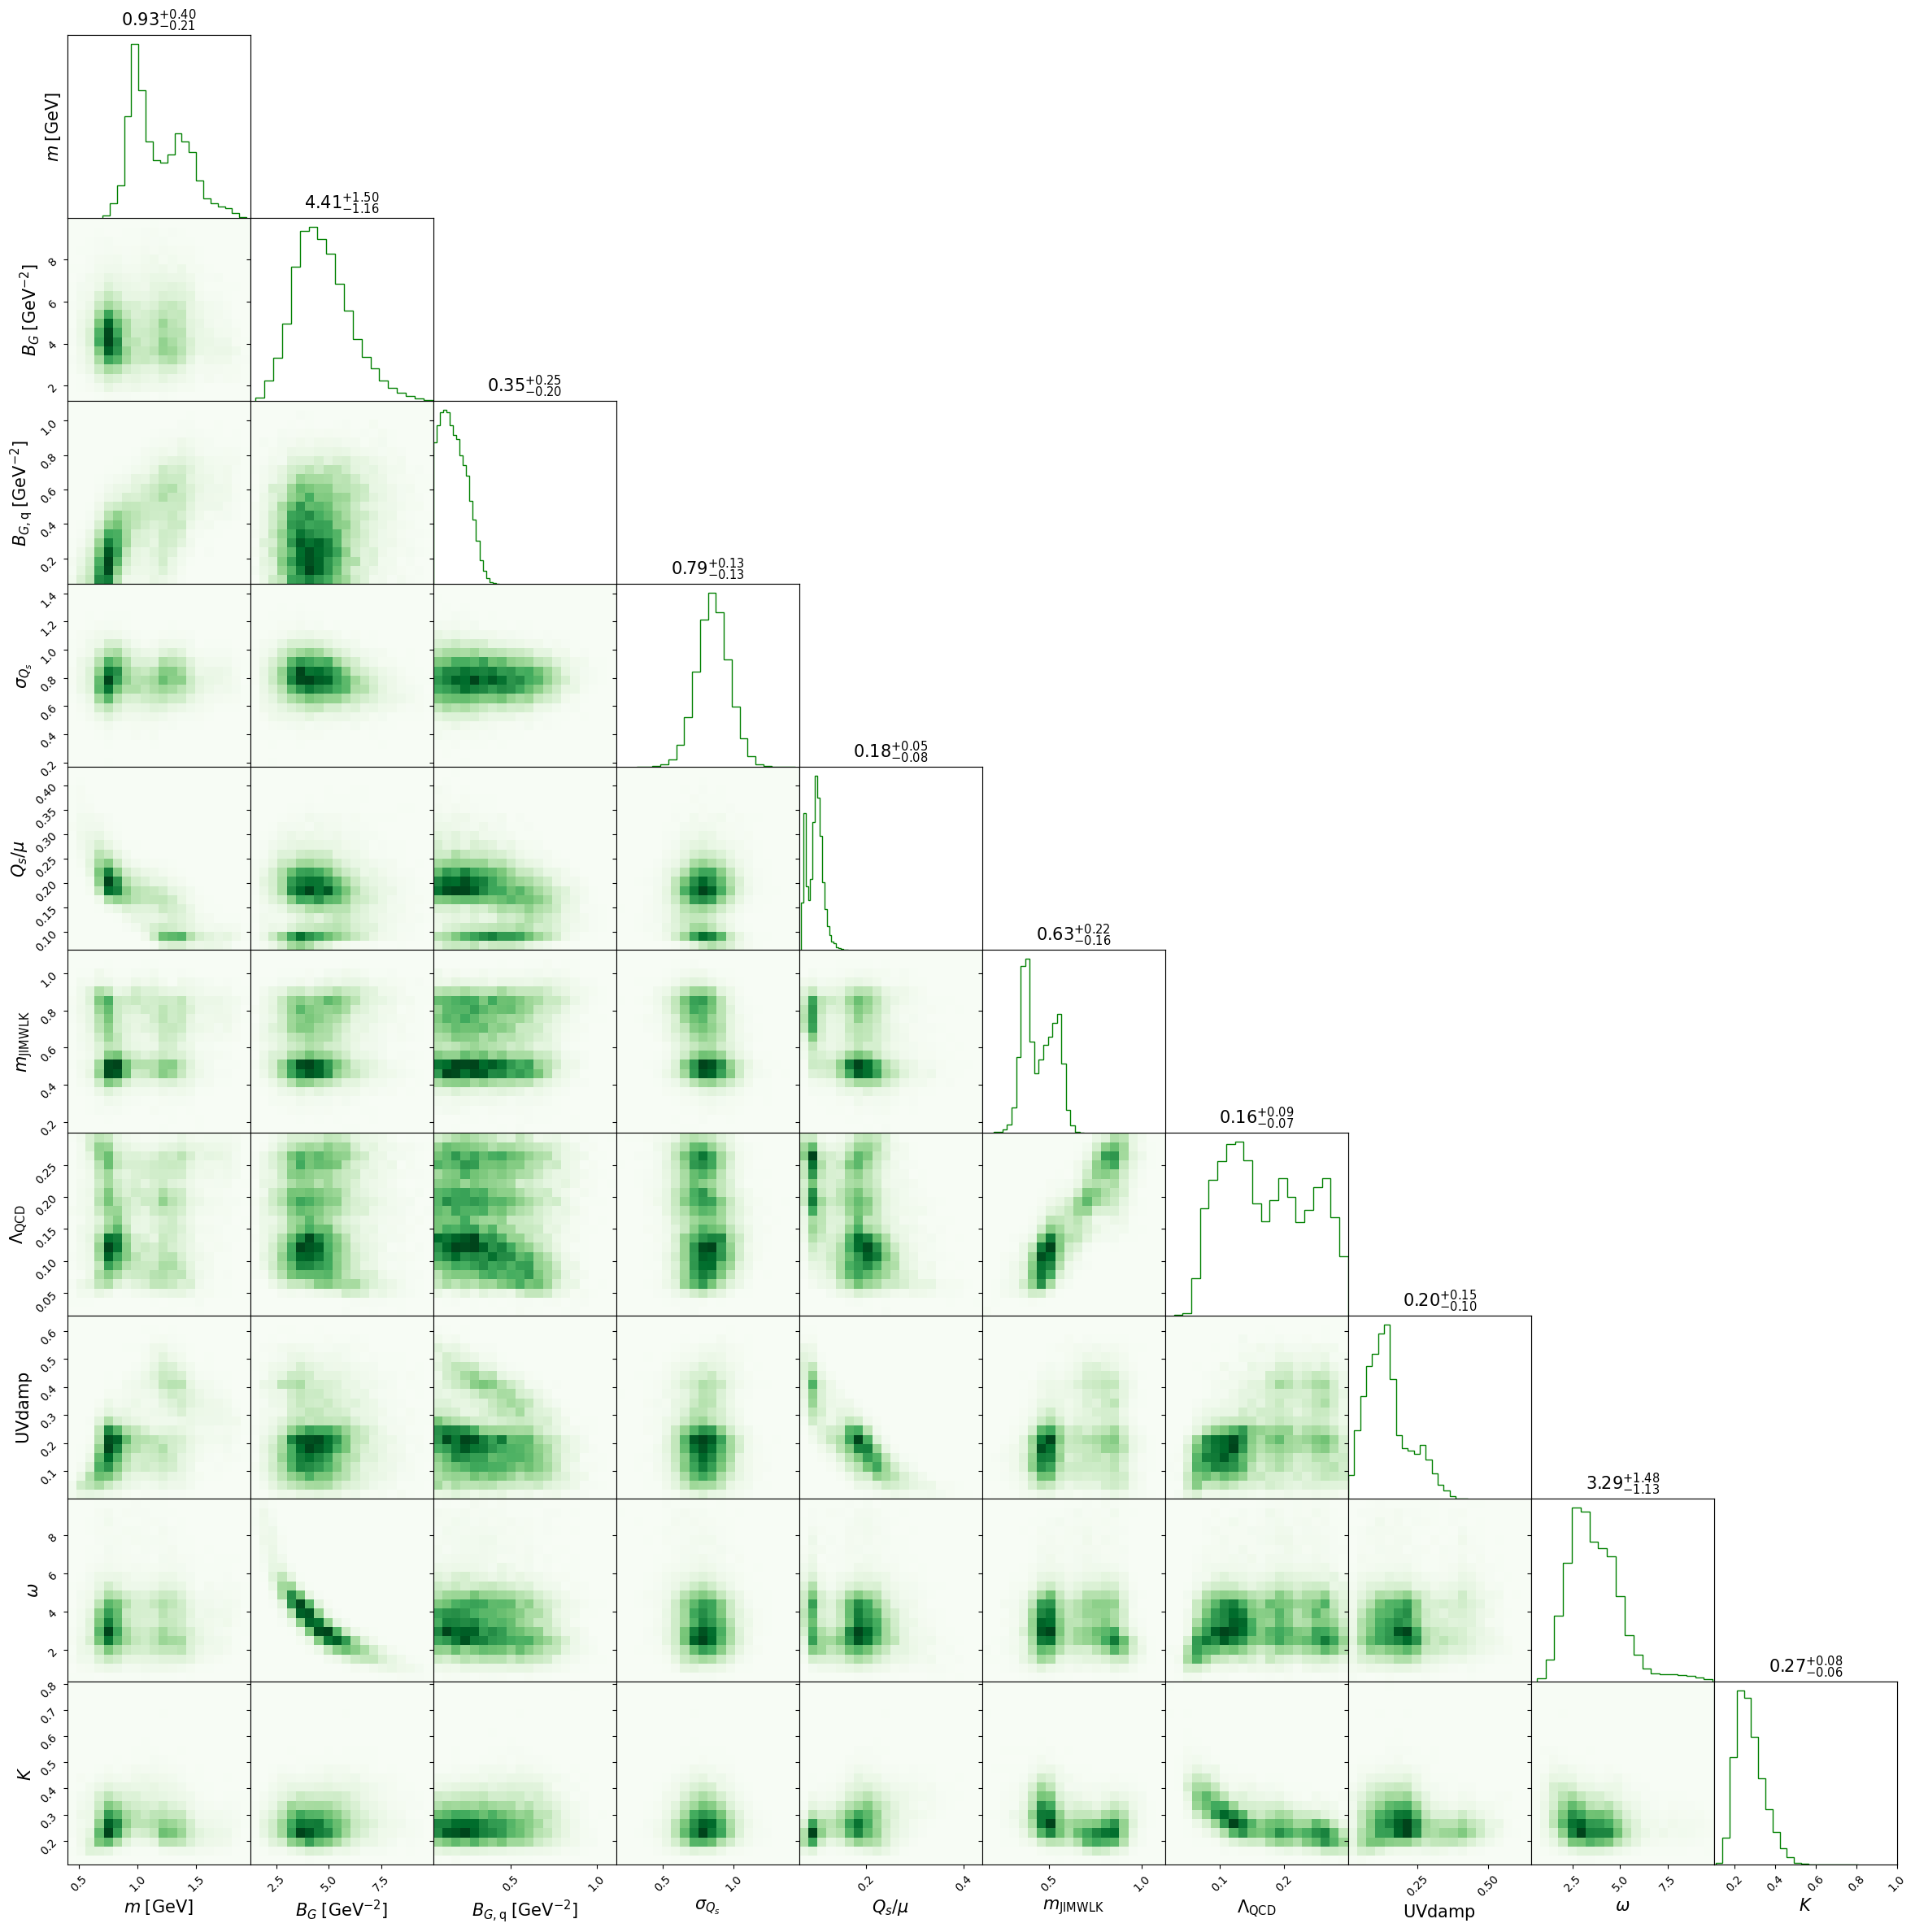

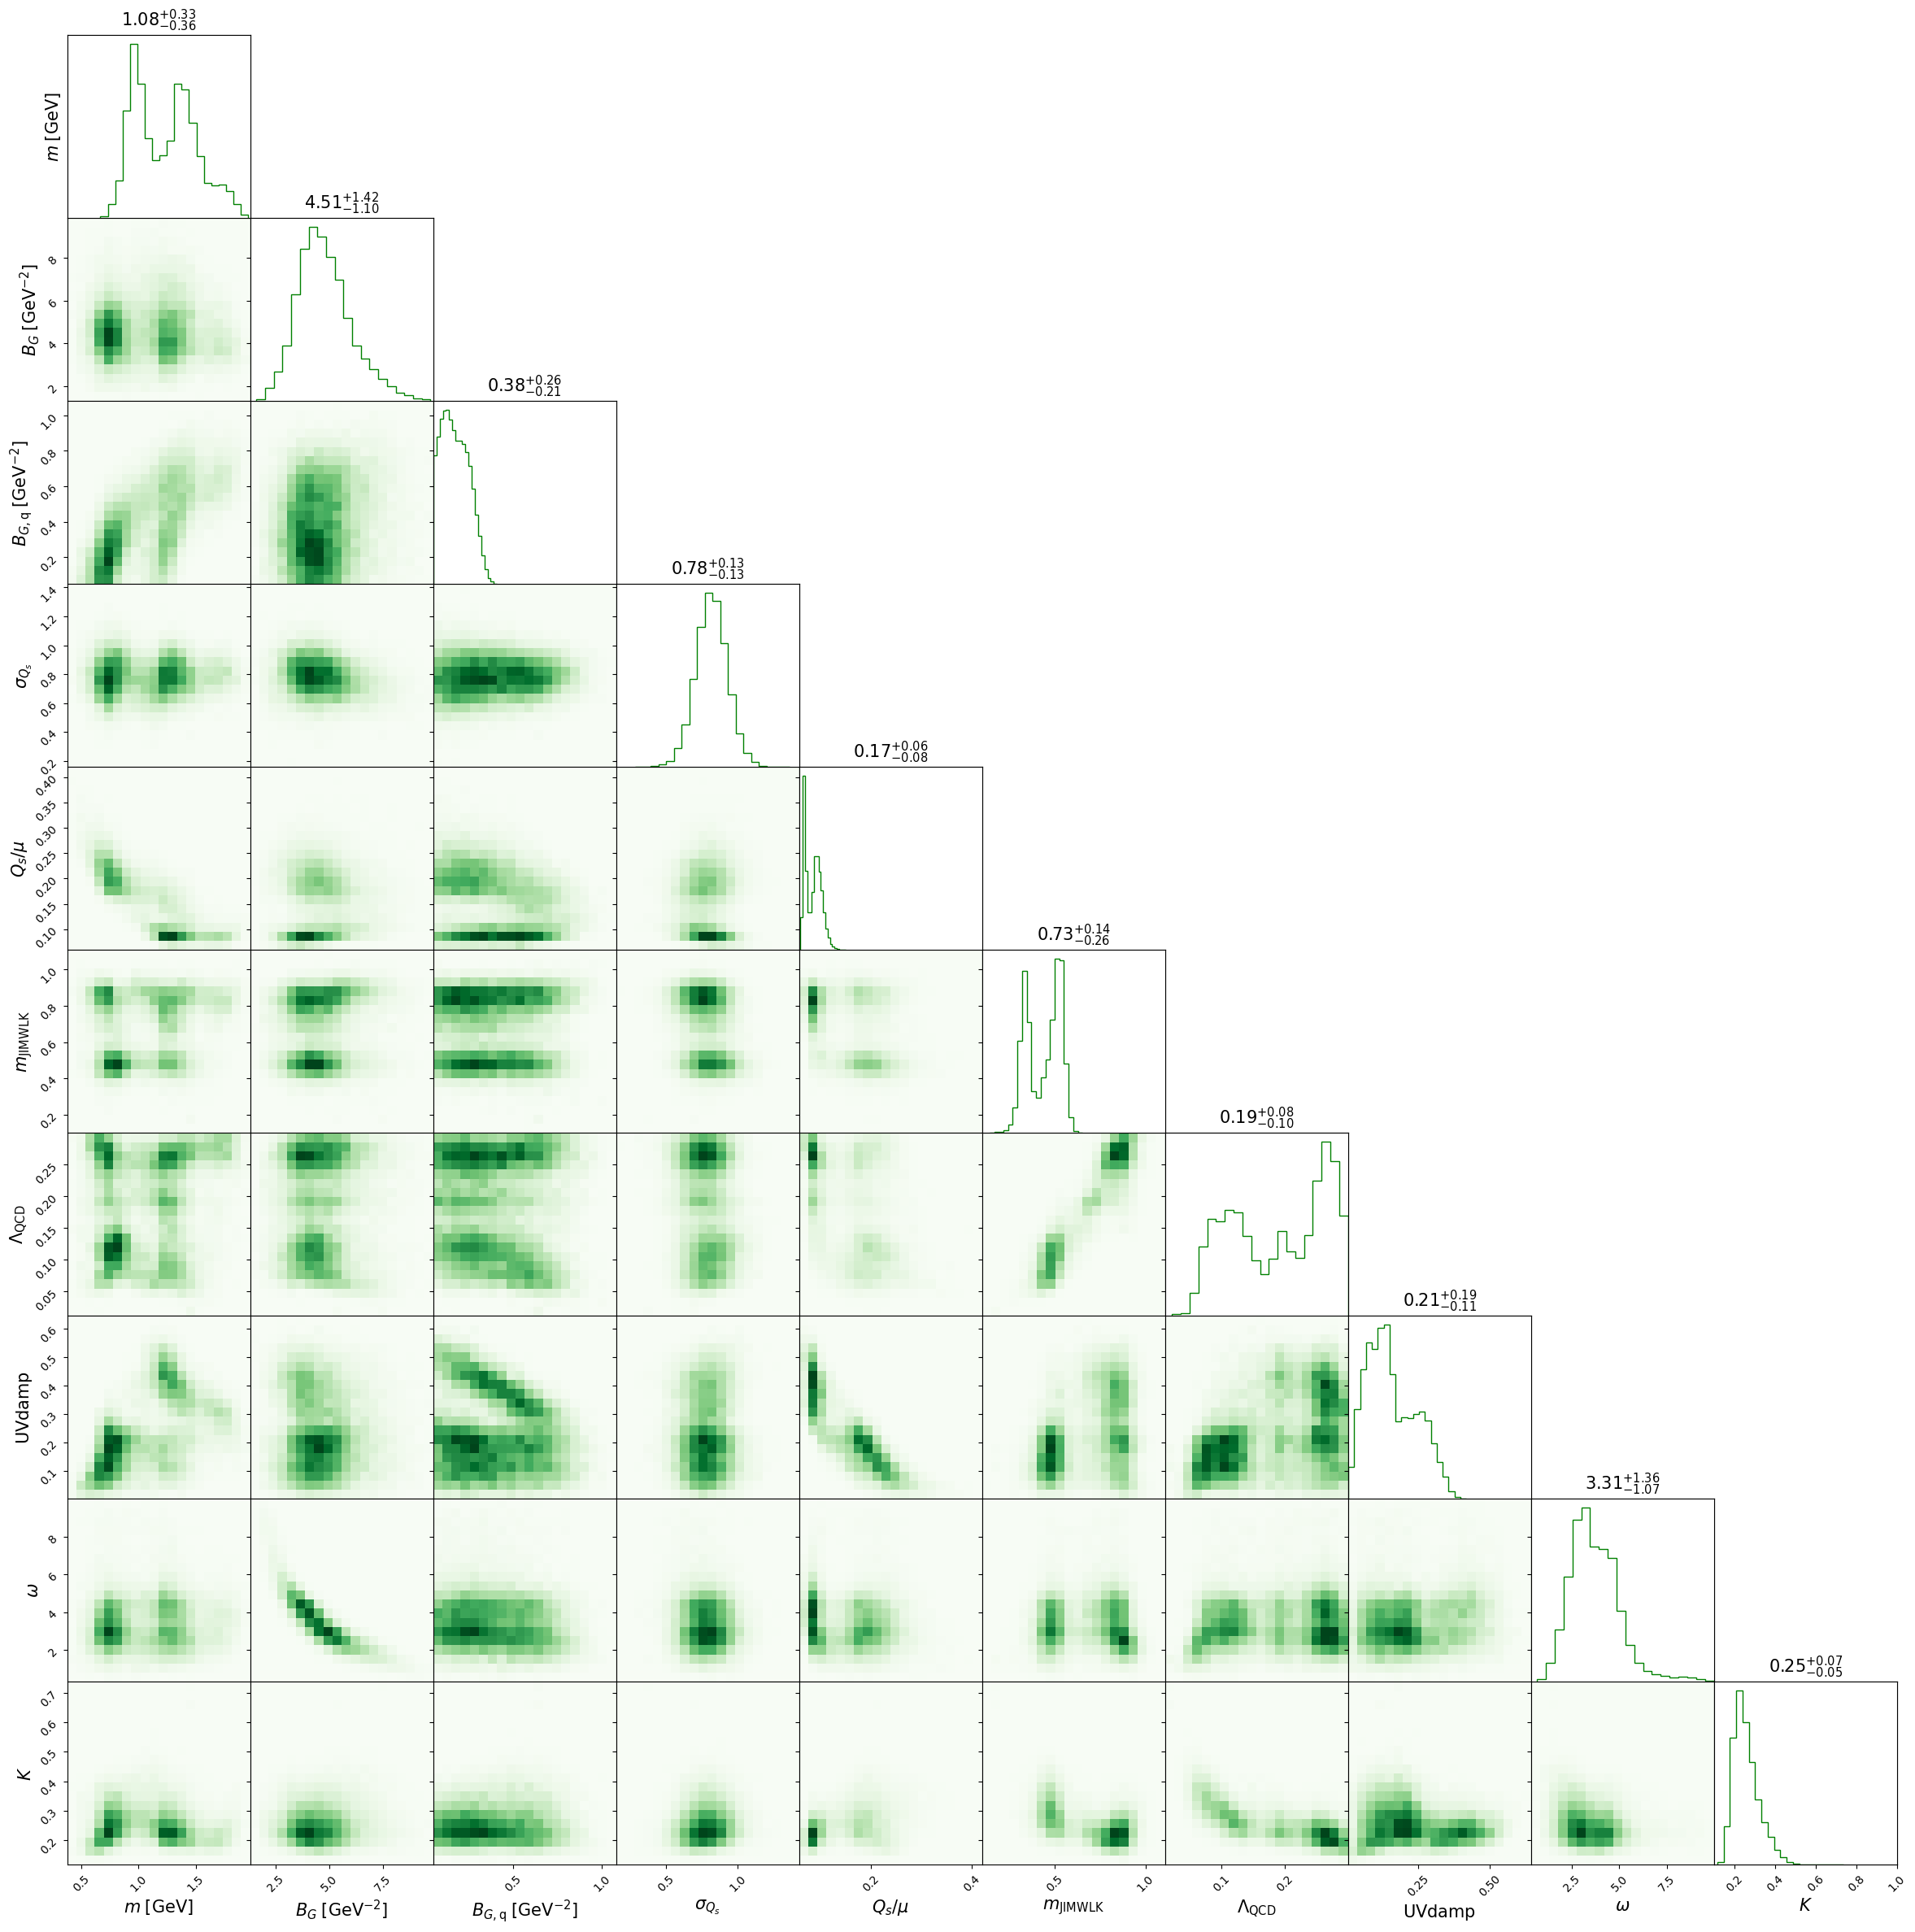

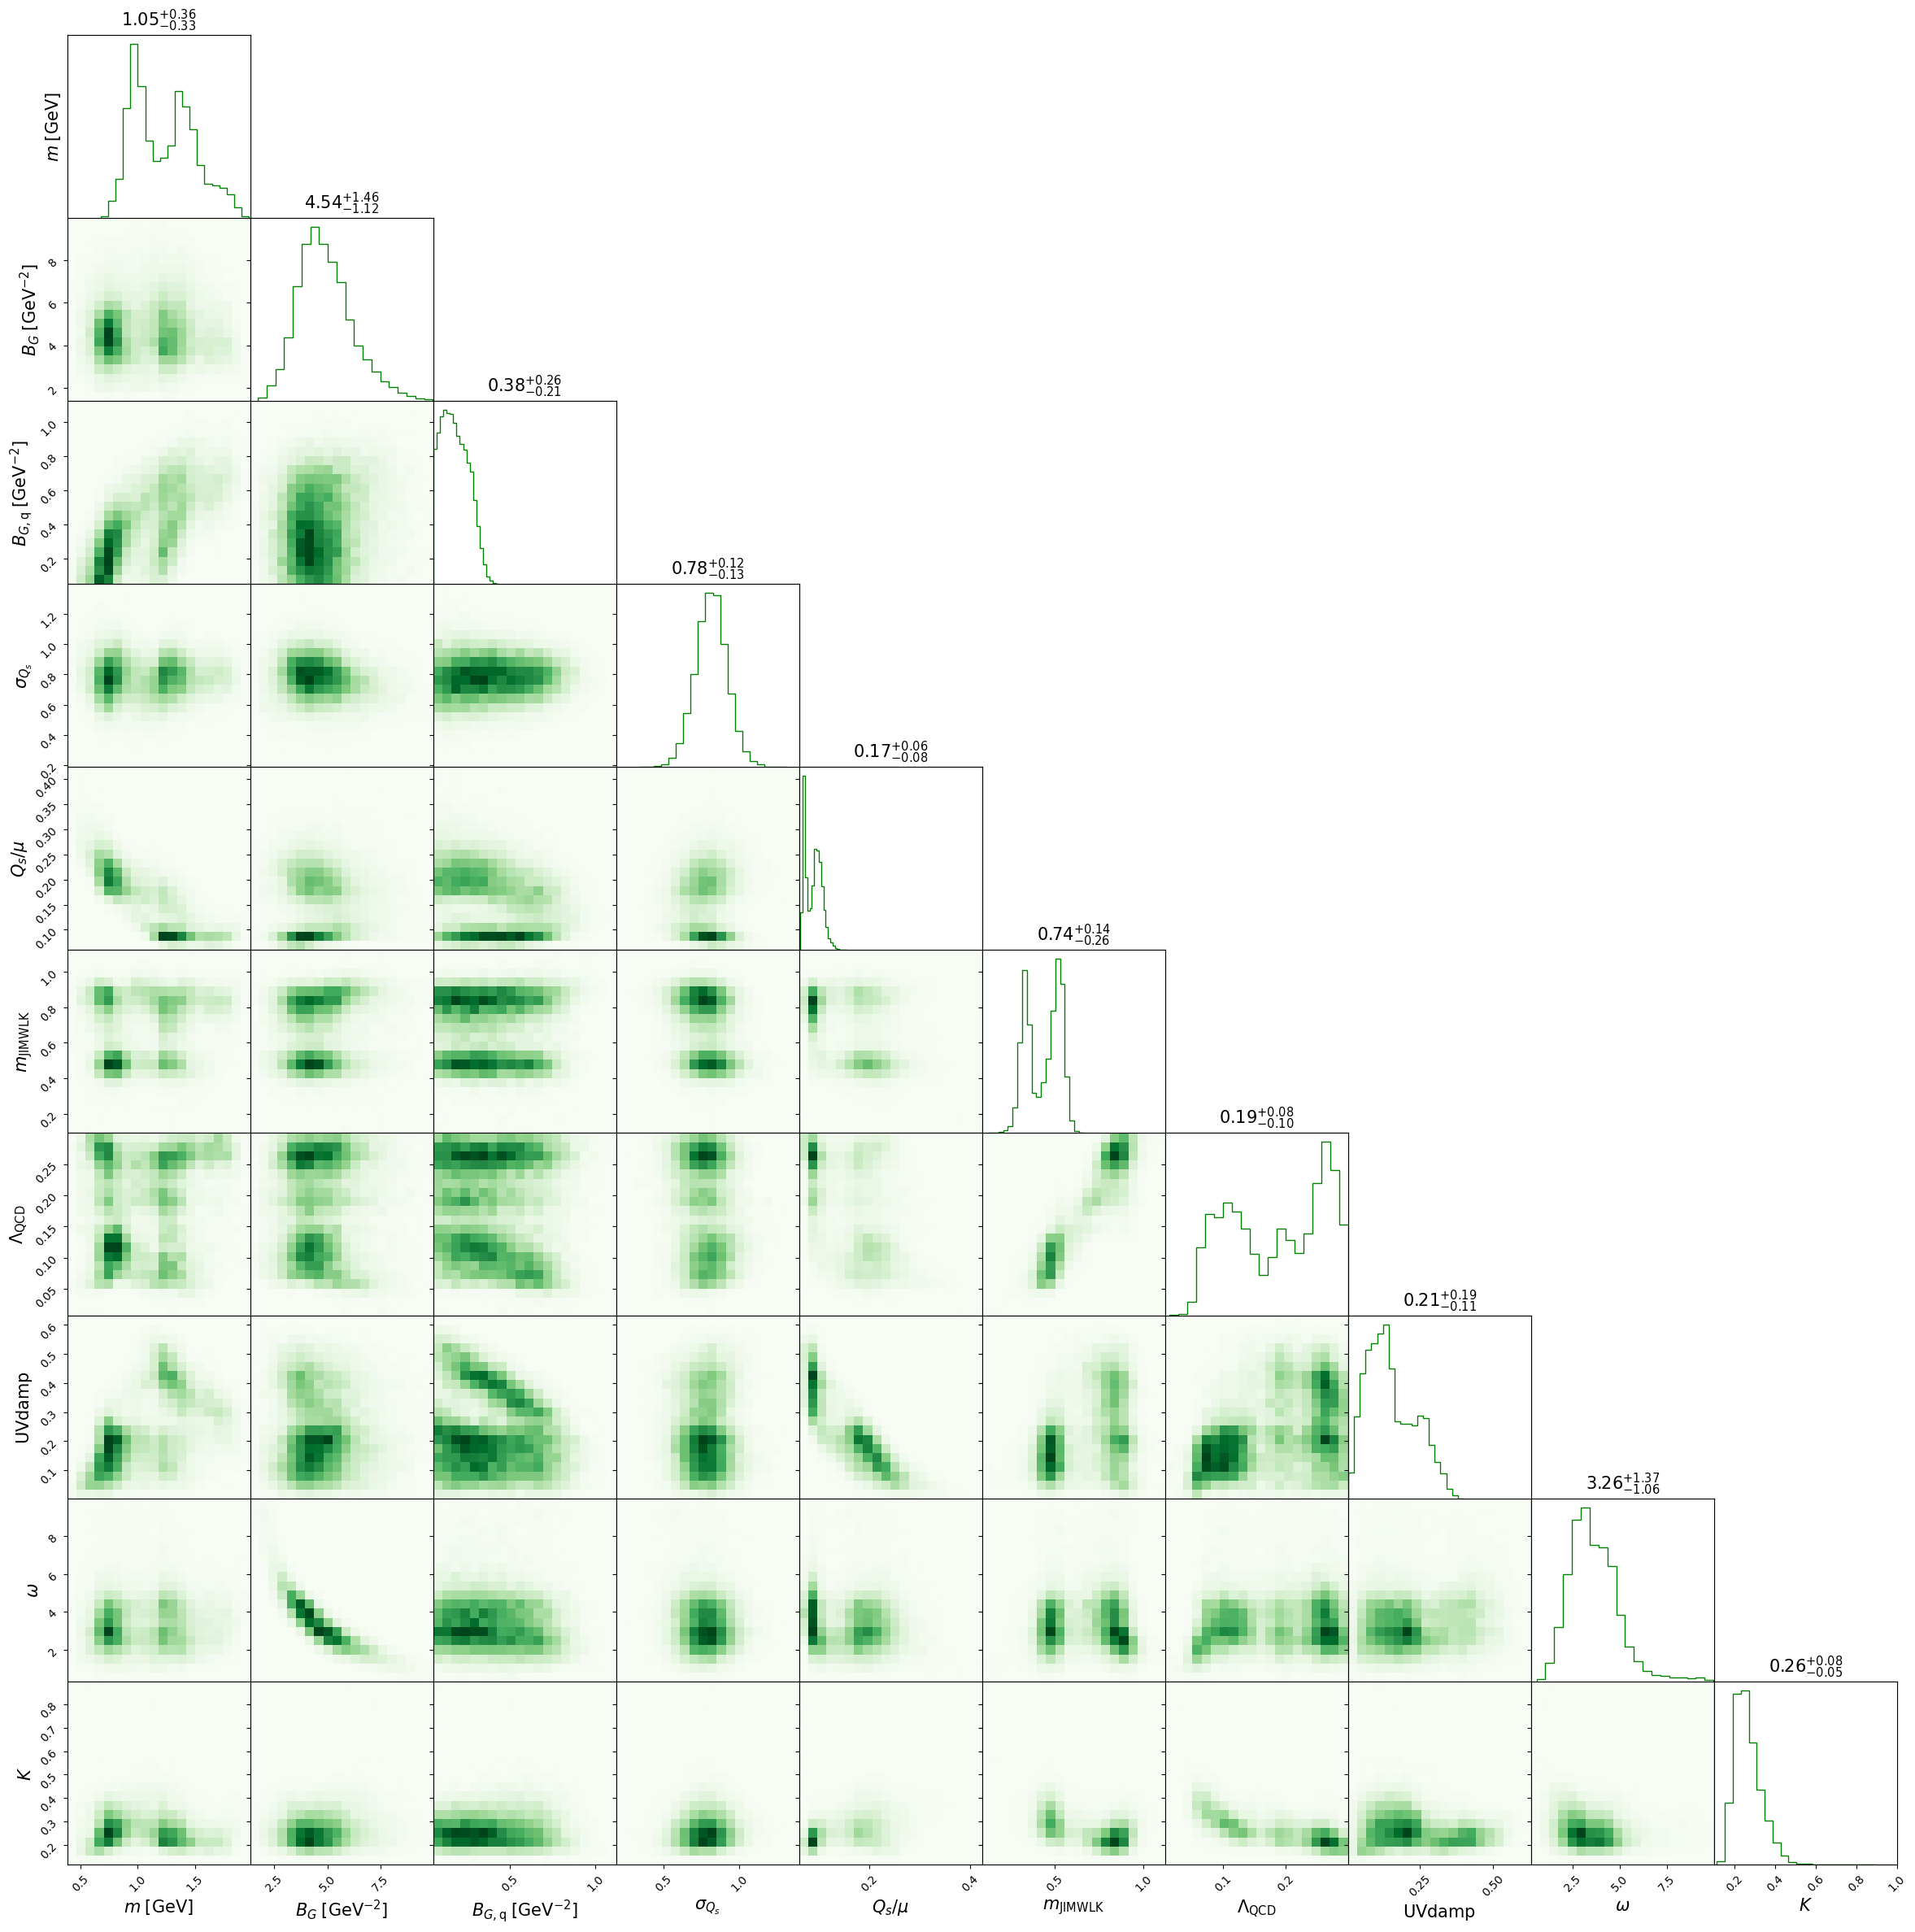

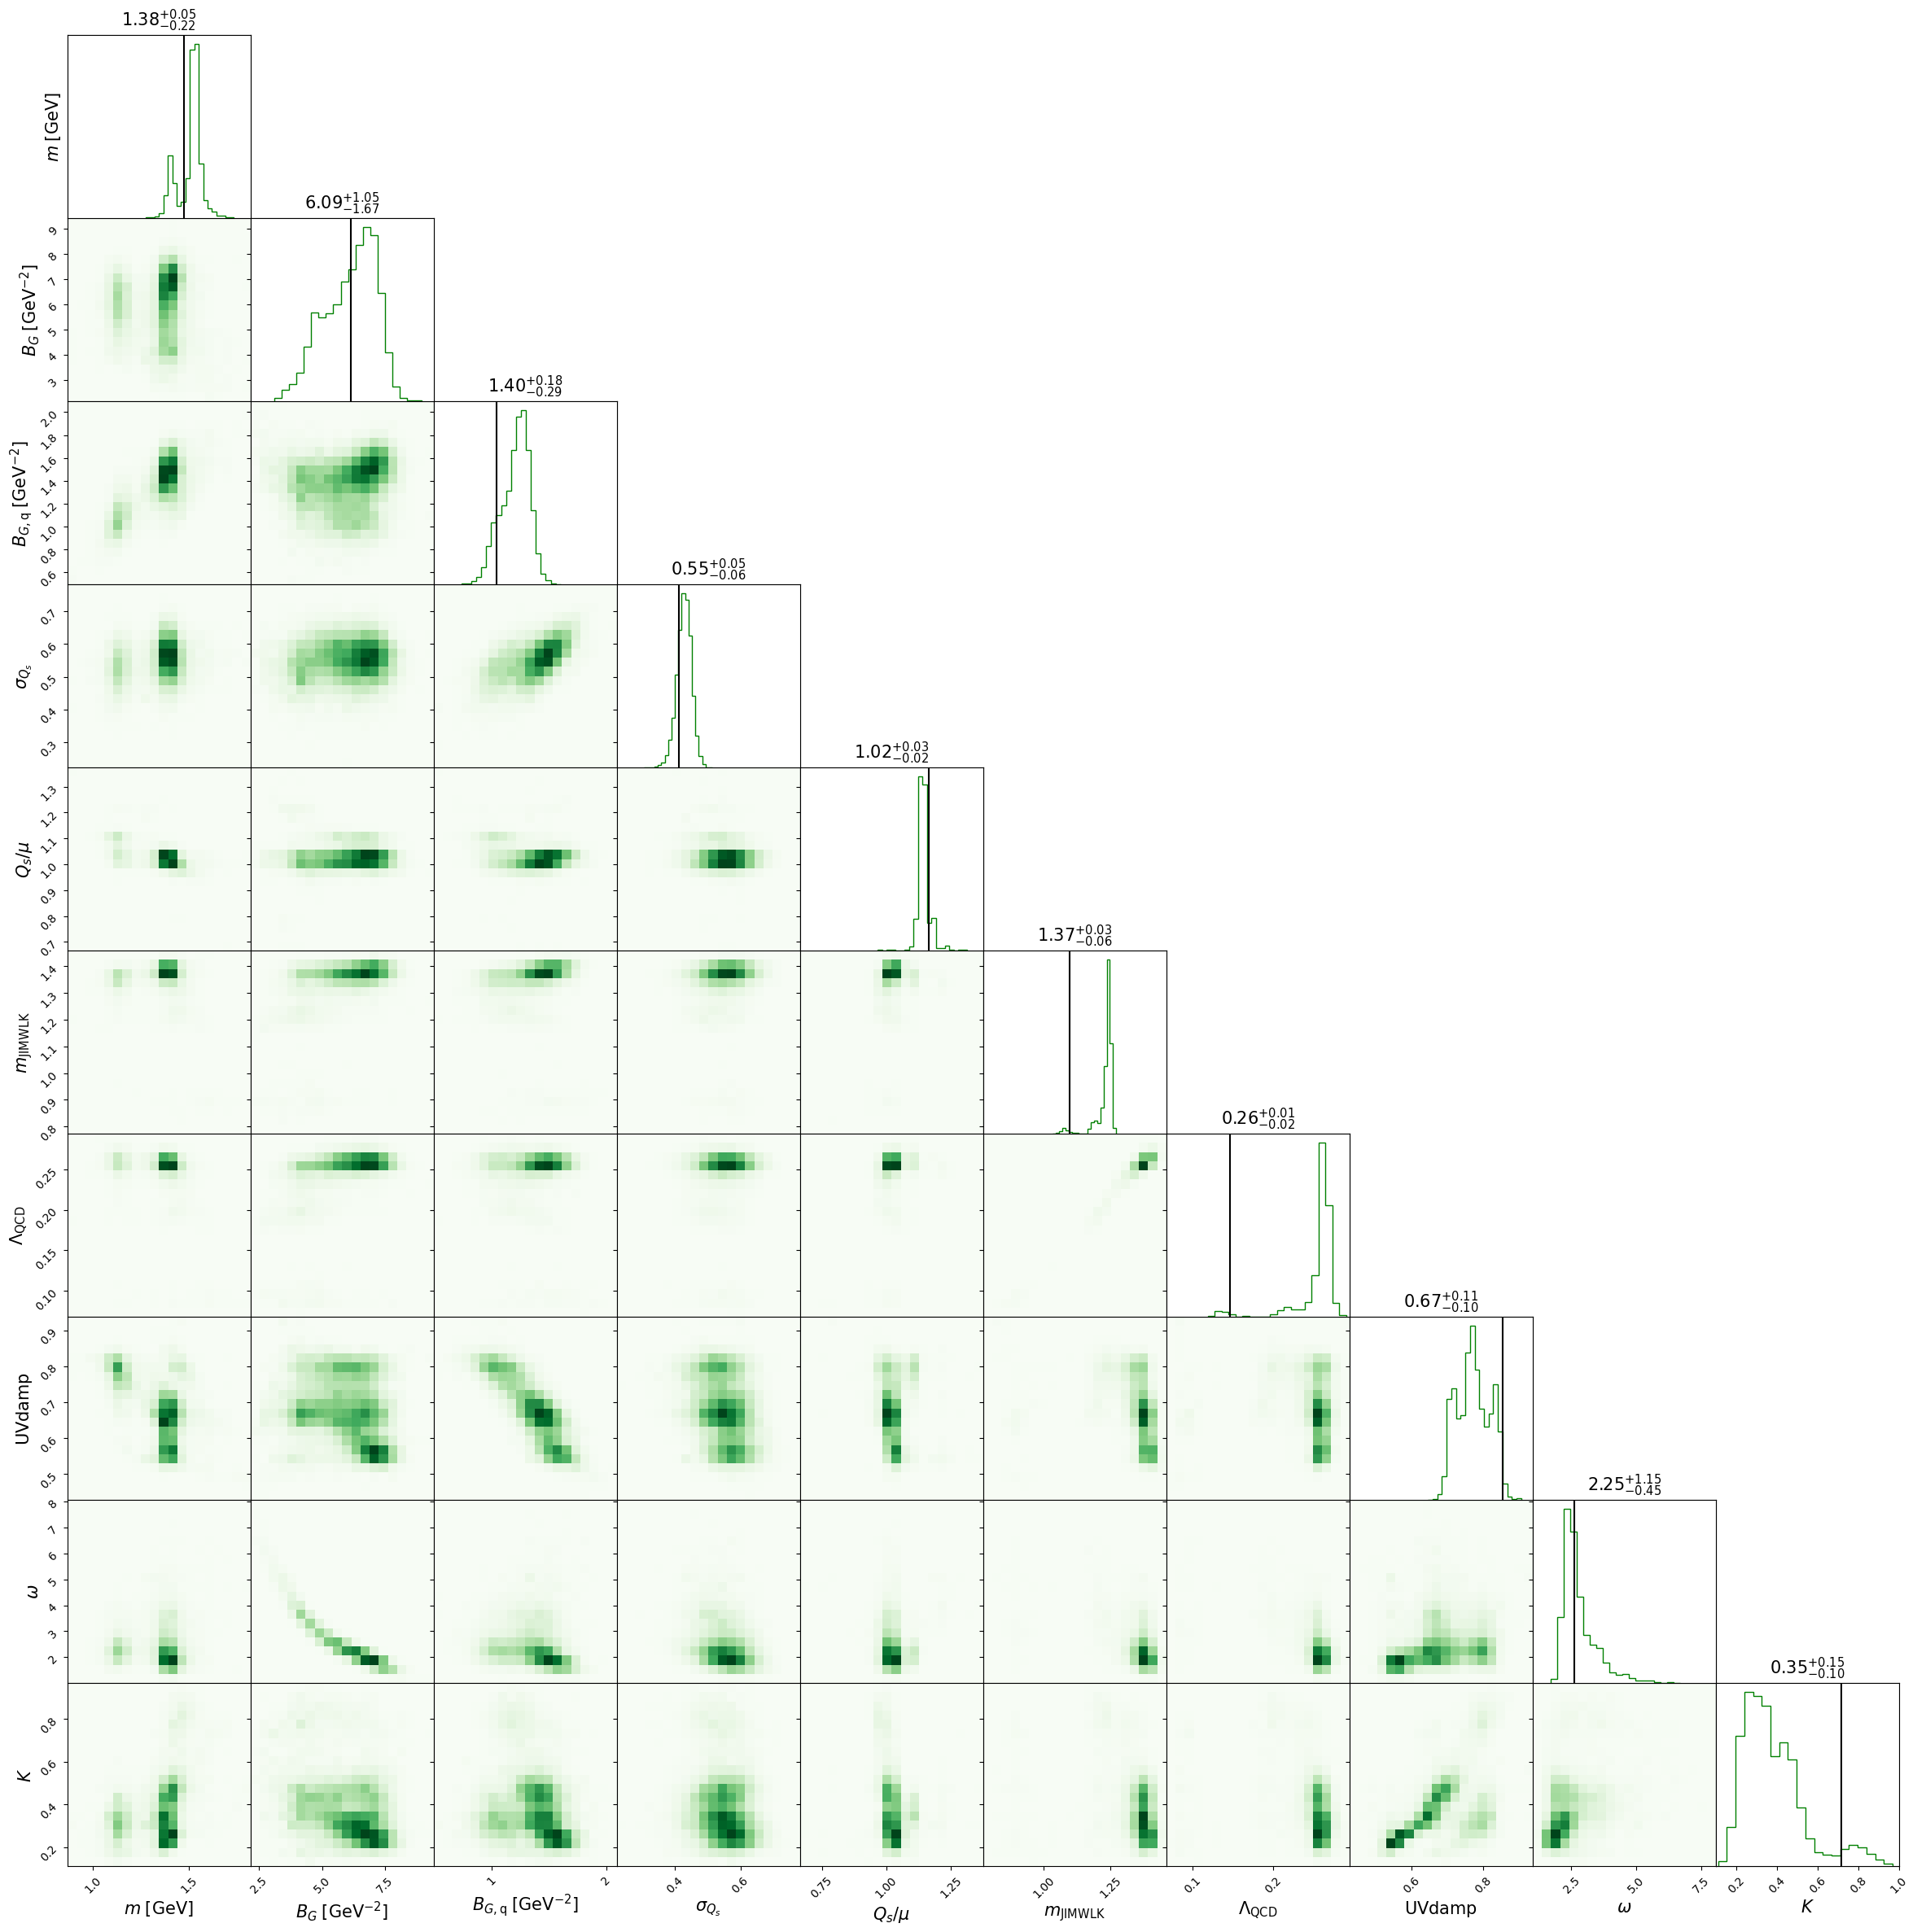

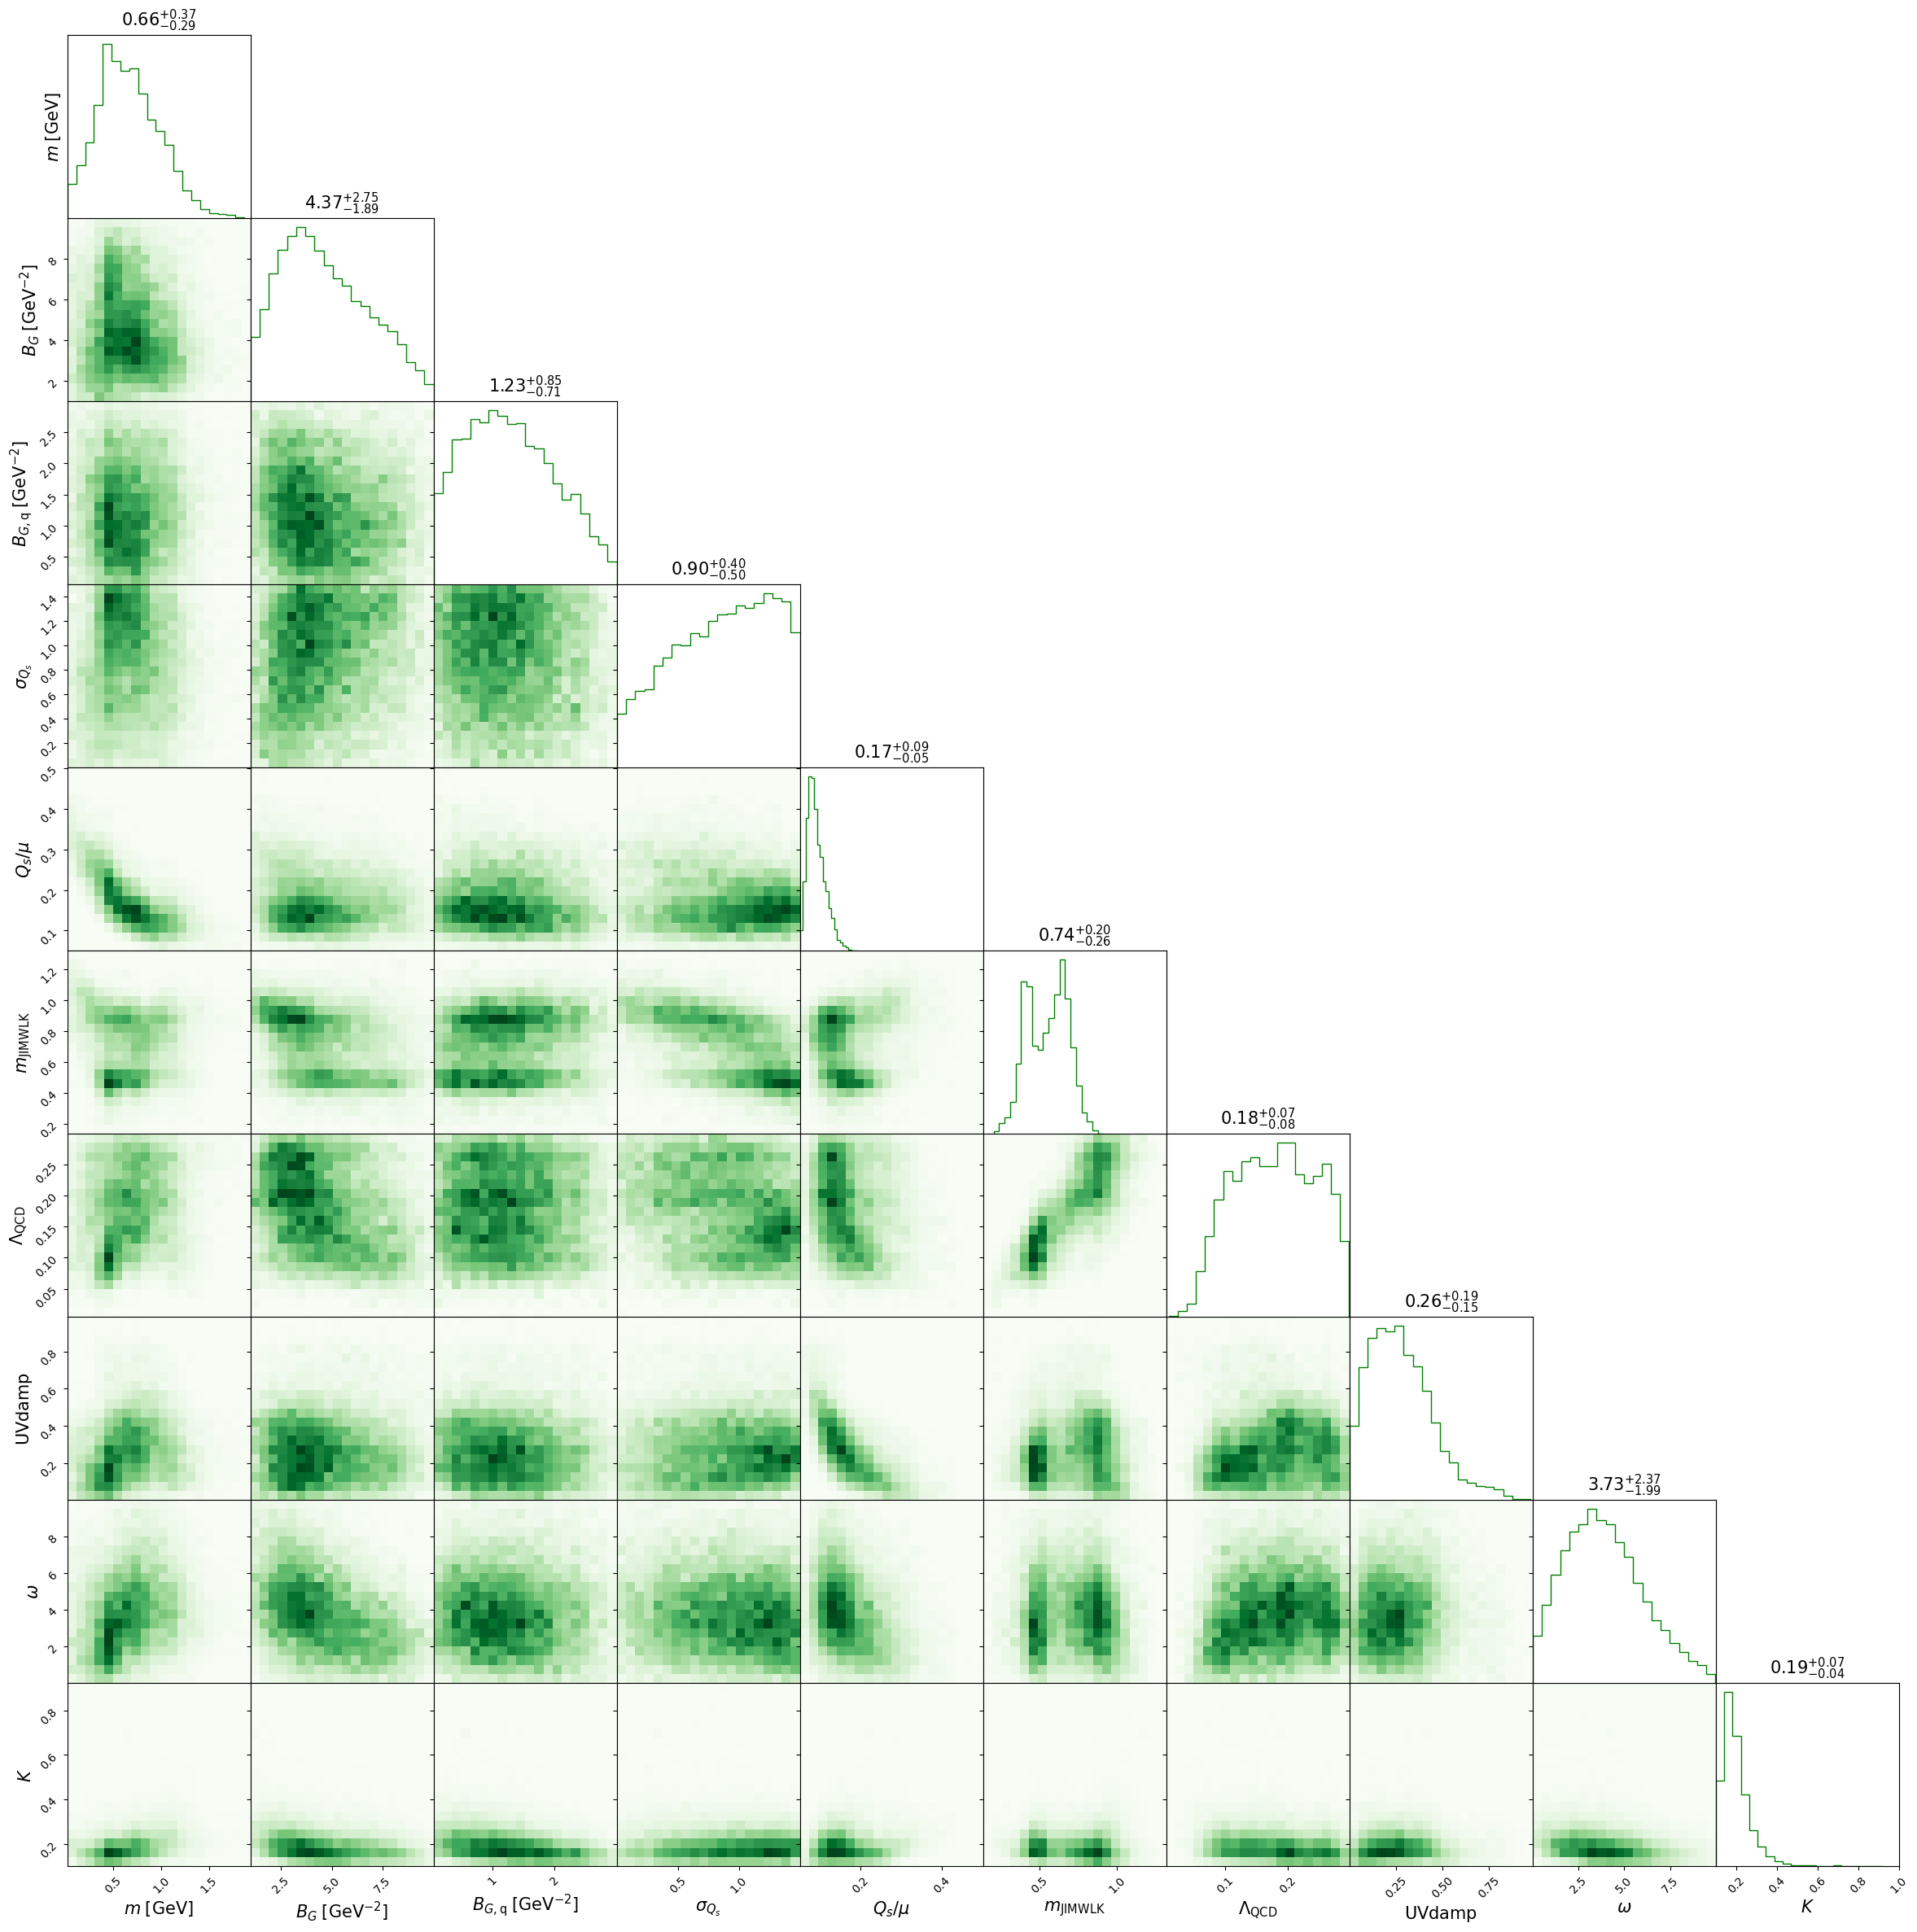

In [8]:
plot_corner_1dataset(10,RUN1_DATA['chain'],'corner_plot_PCSK_noexpcov',real_parameters=None)
plot_corner_1dataset(10,RUN2_DATA['chain'],'corner_plot_PCSK_fullexpcov',real_parameters=None)
plot_corner_1dataset(10,RUN3_DATA['chain'],'corner_plot_PCSK_CMSexpcov',real_parameters=None)
plot_corner_1dataset(10,RUN4_DATA['chain'],'corner_plot_PCSK_ALICEexpcov',real_parameters=None)
plot_corner_1dataset(10,RUN5_DATA['chain'],'corner_plot_PCSK_offzeroexpcov',real_parameters=None)
plot_corner_1dataset(10,RUN6_DATA['chain'],'corner_plot_PCSK_closure',real_parameters=real_parameters)
plot_corner_1dataset(10,RUN7_DATA['chain'],'corner_plot_PCSK_notdiffexpcov',real_parameters=None)

In [ ]:
PATH_pklfile = './mcmc_PCSK_closure_test/chain.pkl'
RUN1_DATA_CLOSURE = read_pkl_file_chain_pocoMC(PATH_pklfile)

PATH_pklfile = './mcmc_Scikit_closure_test/chain.pkl'
RUN2_DATA_CLOSURE = read_pkl_file_chain_pocoMC(PATH_pklfile)

PATH_REAL_PARAMETERS = './closure_test_point_JIMWLK.pkl'
REAL_PARAMETERS = read_real_parameters(PATH_REAL_PARAMETERS)

In [ ]:
plot_corner_1dataset(10,RUN1_DATA_CLOSURE['chain'],'corner_plot_PCSK_closure',real_parameters=REAL_PARAMETERS)
plot_corner_1dataset(10,RUN2_DATA_CLOSURE['chain'],'corner_plot_scikit_closure',real_parameters=REAL_PARAMETERS)

# Extract the MAP parameters using the GP emulator and the optimize function

In [ ]:
# second method to find the maximum likelihood
from scipy import optimize
from src.mcmc import Chain

bound_min = [a[0] for a in prior_ranges]
bound_max = [b[1] for b in prior_ranges]
bounds = [(a,b) for (a,b) in zip(bound_min,bound_max)]

rslt_PCSK = optimize.differential_evolution(lambda x: -mymcmc_PCSK.log_likelihood(x.T), 
                                        bounds=bounds,
                                        maxiter=10000,
                                        disp=True,
                                        tol=1e-9,
                                        vectorized=True,
                                        )
print(rslt_PCSK.x)

# print the MAP parameters to file
with open('MAP_parameters_JIMWLK_PCSK.dat','w') as f:
    for i in range(len(rslt_PCSK.x)):
        f.write(f'{PARAMETER_NAMES[i]}: {rslt_PCSK.x[i]}\n')

rslt_Scikit = optimize.differential_evolution(lambda x: -mymcmc_Scikit.log_likelihood(x.T),
                                        bounds=bounds,
                                        maxiter=10000,
                                        disp=True,
                                        tol=1e-9,
                                        vectorized=True,
                                        )
print(rslt_Scikit.x)

# print the MAP parameters to file
with open('MAP_parameters_JIMWLK_Scikit.dat','w') as f:
    for i in range(len(rslt_Scikit.x)):
        f.write(f'{PARAMETER_NAMES[i]}: {rslt_Scikit.x[i]}\n')
